In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Kuzushiji-MNIST dataset
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

In [6]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [7]:
# Autoencoder
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.8521525859832764
Epoch [2/5], Loss: 0.8579667806625366
Epoch [3/5], Loss: 0.8122833371162415
Epoch [4/5], Loss: 0.8020141124725342
Epoch [5/5], Loss: 0.799837589263916


In [8]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Partition

In [14]:
# cluster: 6, CLient: 10

In [17]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic Dataloaders

In [19]:
trainingset = train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 4

In [21]:

partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=num_clients, alpha=alpha)

# Normal loader classic
classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_strong, train_loader, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_strong = []
test_fashion(trial_model_strong,test_loader,test_losses_classic_strong)



for round_idx in range(rounds_classic):
    
    print(f"Round {round_idx + 1}/{rounds_classic}")

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,test_loader,test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)

    # Save results for non-clustered classic
    results["classic"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)


    ######################
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data

    # Clustered loader classic
    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_classic = []
            for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_classic.append(client_weights)
                
        
            global_weights_classic = federated_averaging(local_weights_classic)
        
        
            distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
        
            distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
            test_losses = []
            test_fashion(global_model_classic_strong,test_loader,test_losses)
    
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data = data.view(data.shape[0], -1)
                    output = global_model_classic_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if num_cluster not in clusteredResults["classic"]:
                clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": []}
    
            clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
            clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313190
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.263790
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.273433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.262154
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.227571
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.154624
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.109187
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.105806
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.005012
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.941321
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.914680
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.741065
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.679722
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.644623
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.519399
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.513030
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.475740
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.342656
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.092968
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.128080
Train Epoch: 1 [12800/60000 (

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5566, Accuracy: 8308/10000 (83%)

Round 1/4
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.288544
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.056769
Train Epoch: 1 [1280/2540 (50%)]	Loss: 1.695348
Train Epoch: 1 [1920/2540 (75%)]	Loss: 1.686186
Train Epoch: 2 [0/2540 (0%)]	Loss: 1.501861
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.523053
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.356141
Train Epoch: 2 [1920/2540 (75%)]	Loss: 1.263085
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.307980
Train Epoch: 3 [640/2540 (25%)]	Loss: 1.303631
Train Epoch: 3 [1280/2540 (50%)]	Loss: 1.008255
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.981741
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.935312
Train Epoch: 4 [640/2540 (25%)]	Loss: 1.170861
Train Epoch: 4 [1280/2540 (50%)]	Loss: 1.124555
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.716949
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.720085
Train Epoch: 5 [640/2540 (25%)]	Loss: 1.000592
Train Epoch: 5 [1280/2540 (50%)]	Loss: 1.064502
Train Epoch: 5 [1920/2540 (

In [22]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.8860758178710938], 'accuracy': [71.78]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [1.005922181224823, 1.0221280888557434, 0.9631275268554688, 0.9794888961791992], 'accuracy': [68.88, 69.09, 71.25, 71.4]}, 4: {'losses': [0.8362515803337097, 0.7984890810012817, 0.7757280477523804, 0.7778336191177369], 'accuracy': [74.4, 75.56, 76.63, 76.67]}, 6: {'losses': [0.7029169893264771, 0.6623379076957703, 0.6658978364944458, 0.6586258483409881], 'accuracy': [78.46, 79.75, 79.85, 80.34]}, 8: {'losses': [0.6078366241931915, 0.5875780544281006, 0.5794325012683869, 0.584261554813385], 'accuracy': [81.63, 82.36, 82.7, 82.51]}, 10: {'losses': [0.5622315493106842, 0.5494817687988282, 0.5415845841407776, 0.535874552154541], 'accuracy': [83.38, 83.66, 83.88, 84.43]}}, 'pca': {}, 'autoencoder': {}}


# PCA Dataloaders

In [23]:
# pca 
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()


In [24]:

partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = [
    DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_pca.values()
]

local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

# Pca strong
optimizer = optim.SGD(trial_model_pca_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_pca_strong, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)

test_losses_pca_strong = []
test_fashion(trial_model_pca_strong,train_loader_reduced_pca,test_losses_pca_strong)

rounds_pca = 4
for round_idx in range(rounds_pca):
    
    print(f"Round {round_idx + 1}/{rounds_pca}")

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_classic.append(accuracy)

    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ##############33
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]


    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_pca = []
            for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_pca.append(client_weights)
                
        
            global_weights_pca = federated_averaging(local_weights_pca)
        
            distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
        
            distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
            test_losses = []
            test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader_pca:
                    data = data.view(data.shape[0], -1)
                    output = global_model_pca_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader_pca.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if num_cluster not in clusteredResults["pca"]:
                clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": []}
    
            clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
            clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299503
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.146139
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.851065
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.527430
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.475298
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.180318
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.049217
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.257176
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.785197
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.938472
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.055520
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.828965
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.666180
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.693440
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.010396
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.877096
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.790987
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.827537
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.539456
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.955342
Train Epoch: 1 [12800/60000 (

In [25]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.8860758178710938], 'accuracy': [71.78]}}, 'pca': {'NoCluster': {'losses': [1.1045524242401124], 'accuracy': [78.88]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [1.005922181224823, 1.0221280888557434, 0.9631275268554688, 0.9794888961791992], 'accuracy': [68.88, 69.09, 71.25, 71.4]}, 4: {'losses': [0.8362515803337097, 0.7984890810012817, 0.7757280477523804, 0.7778336191177369], 'accuracy': [74.4, 75.56, 76.63, 76.67]}, 6: {'losses': [0.7029169893264771, 0.6623379076957703, 0.6658978364944458, 0.6586258483409881], 'accuracy': [78.46, 79.75, 79.85, 80.34]}, 8: {'losses': [0.6078366241931915, 0.5875780544281006, 0.5794325012683869, 0.584261554813385], 'accuracy': [81.63, 82.36, 82.7, 82.51]}, 10: {'losses': [0.5622315493106842, 0.5494817687988282, 0.5415845841407776, 0.535874552154541], 'accuracy': [83.38, 83.66, 83.88, 84.43]}}, 'pca': {2: {'losses': [1.0944472249031068, 1.051541649723053

# Autoencoder Dataloader

In [26]:
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()

In [27]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

# Normal loader autoencoder
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

# Auto strong
optimizer = optim.SGD(trial_model_auto_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_auto_strong, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

test_losses_auto_strong = []
test_fashion(trial_model_auto_strong,reduced_train_loader_auto,test_losses_auto_strong)

rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    
    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_auto.dataset)
    test_accuracies_classic.append(accuracy)
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ######################
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": []}
        
        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297513
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304655
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.290598
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.300459
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.292198
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.303570
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.294355
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.283441
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.276927
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.286916
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.280189
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.283614
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.273326
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.264126
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.276202
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.274699
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.244898
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.249056
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.238155
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.232281
Train Epoch: 1 [12800/60000 (

In [28]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.8860758178710938], 'accuracy': [71.78]}}, 'pca': {'NoCluster': {'losses': [1.1045524242401124], 'accuracy': [78.88]}}, 'autoencoder': {'NoCluster': {'losses': [1.8365140748977662], 'accuracy': [38.6]}}}
Final Results (Clustered): {'classic': {2: {'losses': [1.005922181224823, 1.0221280888557434, 0.9631275268554688, 0.9794888961791992], 'accuracy': [68.88, 69.09, 71.25, 71.4]}, 4: {'losses': [0.8362515803337097, 0.7984890810012817, 0.7757280477523804, 0.7778336191177369], 'accuracy': [74.4, 75.56, 76.63, 76.67]}, 6: {'losses': [0.7029169893264771, 0.6623379076957703, 0.6658978364944458, 0.6586258483409881], 'accuracy': [78.46, 79.75, 79.85, 80.34]}, 8: {'losses': [0.6078366241931915, 0.5875780544281006, 0.5794325012683869, 0.584261554813385], 'accuracy': [81.63, 82.36, 82.7, 82.51]}, 10: {'losses': [0.5622315493106842, 0.5494817687988282, 0.5415845841407776, 0.535874552154541], 'accuracy': [83.38, 83.66, 83.88, 84.43

# Plot


Non-Clustered Results:
classic:
  Average Loss: {'NoCluster': 0.8860758178710938}
  Average Accuracy: {'NoCluster': 71.78}
pca:
  Average Loss: {'NoCluster': 1.1045524242401124}
  Average Accuracy: {'NoCluster': 78.88}
autoencoder:
  Average Loss: {'NoCluster': 1.8365140748977662}
  Average Accuracy: {'NoCluster': 38.6}


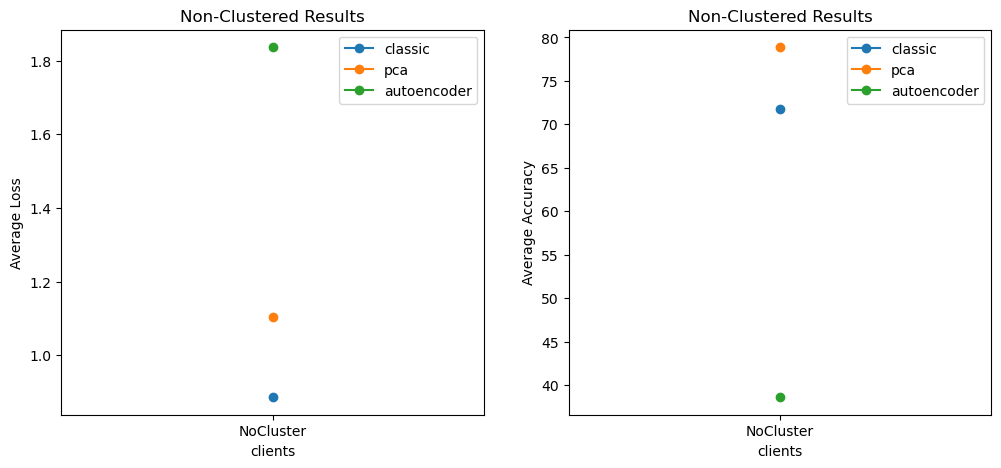


Clustered Results:
classic:
  Average Loss: {2: 0.9926666732788085, 4: 0.7970755820512772, 6: 0.6724446454644204, 8: 0.589777183675766, 10: 0.5472931136012078}
  Average Accuracy: {2: 70.155, 4: 75.815, 6: 79.6, 8: 82.3, 10: 83.8375}
pca:
  Average Loss: {2: 1.0240215480804444, 4: 0.8502713631629945, 6: 0.7584692607164383, 8: 0.7024159495830535, 10: 0.6403755957365035}
  Average Accuracy: {2: 77.22, 4: 81.62, 6: 83.88, 8: 85.51499999999999, 10: 86.6425}
autoencoder:
  Average Loss: {2: 4.354607228183746, 4: 7.007689877700806, 6: 8.49361069946289, 8: 9.707598841476441, 10: 10.554096645355225}
  Average Accuracy: {2: 36.6975, 4: 34.6625, 6: 33.85, 8: 32.95, 10: 32.555}


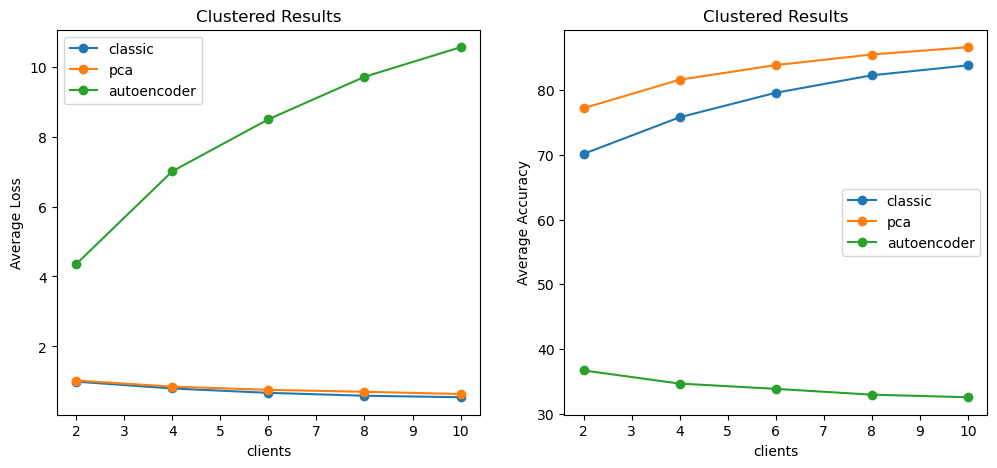

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Loss')
    plt.title(f'{title}')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title}')
    plt.legend()
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")